# CommonLit Readability Prize

In [1]:
%load_ext autoreload
%autoreload 2

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

import re
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

from wordcloud import WordCloud

In [ ]:
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('omw-1.4')

In [182]:
# color palette
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
palette = ["#7209C7","#3F99C5","#146F63","#F62585","#FFBA10"]
sns.set_style("darkgrid")

#palette = sns.diverging_palette(100, 250, n=20)
#sns.palplot(sns.color_palette(palette),size=0.8)
#plt.tick_params(axis='both', labelsize=0, length = 0)

### Data Overview

In [203]:
train_df = pd.read_csv("train.csv")

In [204]:
train_df.sample(5)

,id,url_legal,license,excerpt,target,standard_error
1328,32923648c,NaN,NaN,A few days ago I sat by the bedside of a wound...,-0.929452,0.451381
350,03fccfcee,https://simple.wikipedia.org/wiki/Emancipation...,CC BY-SA 3.0 and GFDL,The Proclamation was issued in two parts. On S...,-0.351183,0.488193
1098,6303d0608,NaN,NaN,"In May 1774, in retaliation for the ""Boston Te...",-1.625327,0.476127
23,66f0a9ff1,NaN,NaN,If nature afflicts in one direction she freque...,-2.386485,0.526079
153,df052152b,NaN,NaN,The Grandcourt match was the only match of the...,-1.758595,0.496718


In [205]:
train_df.columns

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')

In [206]:
train_df.nunique()  # --> continuous target  # missing values visible

id                2834
url_legal          667
license             15
excerpt           2834
target            2834
standard_error    2834
dtype: int64

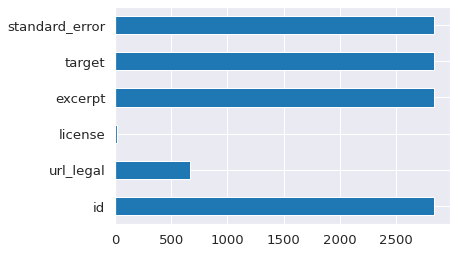

In [207]:
# missing values
train_df.nunique().plot.barh();

### Preprocessing

In [208]:
# preprocessing for analysis
def preprocess_for_analysis(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = nltk.word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    text = [word for word in text if word.casefold() not in stop_words]
    lemmatizer = nltk.WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

In [209]:
example = train_df.iloc[1]["excerpt"]
print("Before preprocessing: \n", example)
example = preprocess_for_analysis(example)
print("\nAfter preprocessing: \n", example)

Before preprocessing: 
 All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.
At last, however, when the meal was nearly over, she smiled at her little daughter, and said, "All right, Dolly, you may go."
"Oh, mother!" Dolly cried, overwhelmed with sudden delight. "Really?
Oh, I am so glad! Are you sure you're willing?"
"I've persuaded myself to be willing, against my will," returned Mrs. Fayre, whimsically. "I confess I just hate to have you go, but I can't bear to deprive you of the pleasure trip. And, as you say, it would also keep Dotty at home, and so, altogether, I think I shall have to give in."
"Oh, you angel mother! You blessed lady! How good you are!" And Dolly flew around the table and gave her mother a hug that nearly suffocated her.

After preprocessing: 
 dinner time Mr

In [210]:
# preprocess dataset
train_df["excerpt_preprocessed"] = train_df["excerpt"].apply(lambda row: preprocess_for_analysis(row))

In [211]:
train_df.head()

,id,url_legal,license,excerpt,target,standard_error,excerpt_preprocessed
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,young people returned ballroom presented decid...
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time Mrs Fayre somewhat silent eye rest...
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,Roger predicted snow departed quickly came two...
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,outside palace great garden walled round fille...
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time Three Bears lived together house woo...


### Visualizations and Analysis

#### Target Distribution

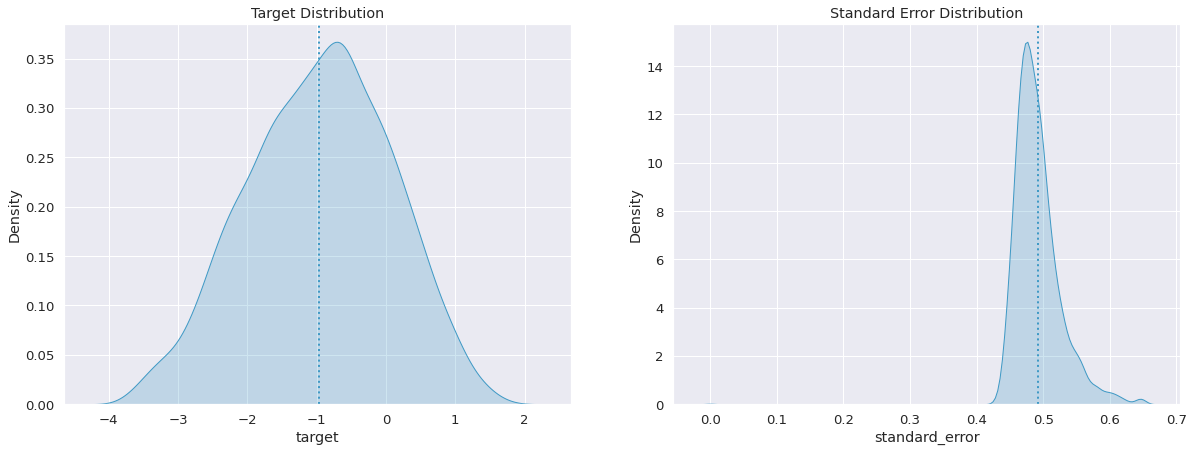

In [284]:
# target distribution
#for dist, title in zip(["target", "standard_error"], ["Target Distribution", "Standard Error Distribution"]):
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
sns.kdeplot(train_df["target"], color=palette[1], shade=True).set_title("Target Distribution")
plt.axvline(train_df["target"].mean(), color=palette[1], linewidth=2, linestyle=":")

plt.subplot(1, 2, 2)
sns.kdeplot(train_df["standard_error"], color=palette[1], shade=True).set_title("Standard Error Distribution")
plt.axvline(train_df["standard_error"].mean(), color=palette[1], linewidth=2, linestyle=":")

plt.show()

#### N-grams

In [207]:
ngram_dict, freqs_dict = dict(), dict()
ngrams_names = ["unigrams", "bigrams", "trigrams", ]
n = [1, 2, 3]

In [210]:
for idx in range(len(n)):
    freqs = Counter([])
    
    for text in train_df["excerpt_preprocessed"]:
        
        n_grams = ngrams(text.split(), n[idx])
        freqs += Counter(n_grams)
    
    common_ngrams = freqs.most_common()

    ngrams_list = [" ".join(word) for word, _ in common_ngrams]
    freqs_list = [freq for _, freq in common_ngrams]
    ngram_dict[ngrams_names[idx]] = ngrams_list
    freqs_dict[ngrams_names[idx]] = freqs_list

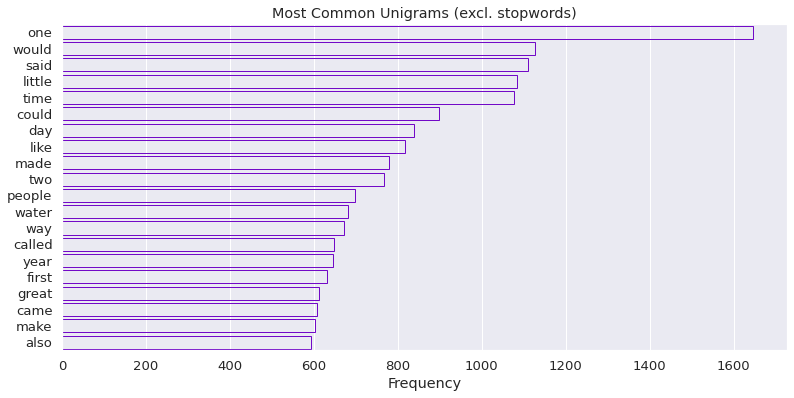

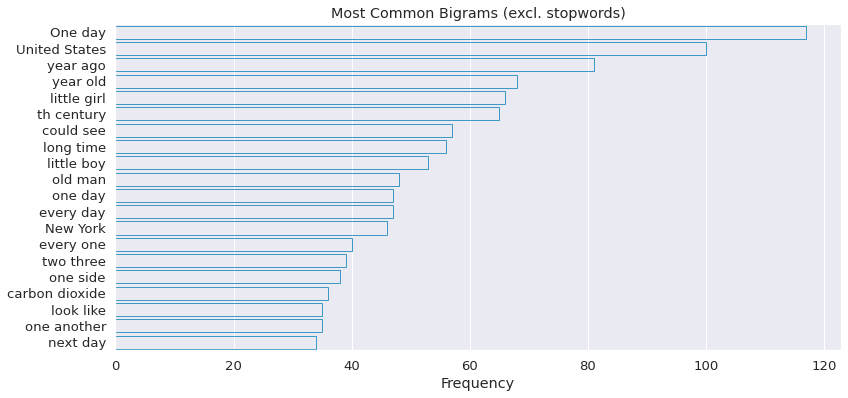

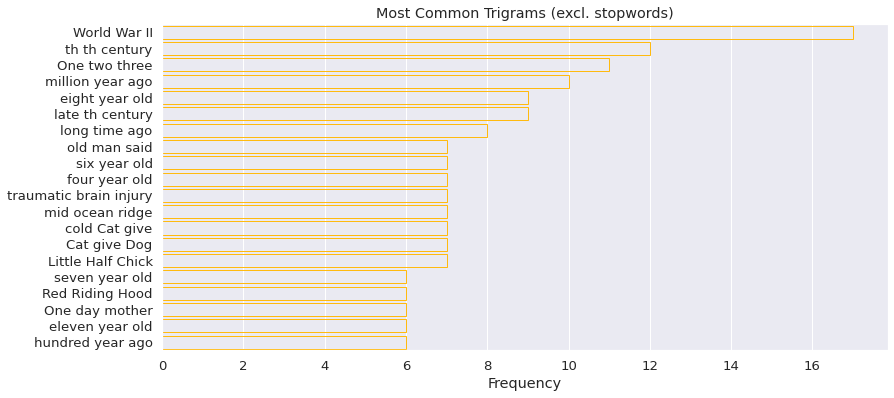

In [285]:
for ngram, color in zip(ngrams_names, [0, 1, 4]):
    plt.figure(figsize=(13, 6))
    sns.barplot(x=freqs_dict[ngram][:20], y=ngram_dict[ngram][:20], facecolor=(0, 0, 0, 0), edgecolor=palette[color], linewidth=1)
    plt.title(f"Most Common {ngram.capitalize()} (excl. stopwords)")
    plt.xlabel("Frequency")
    plt.show()

#### Wordcloud

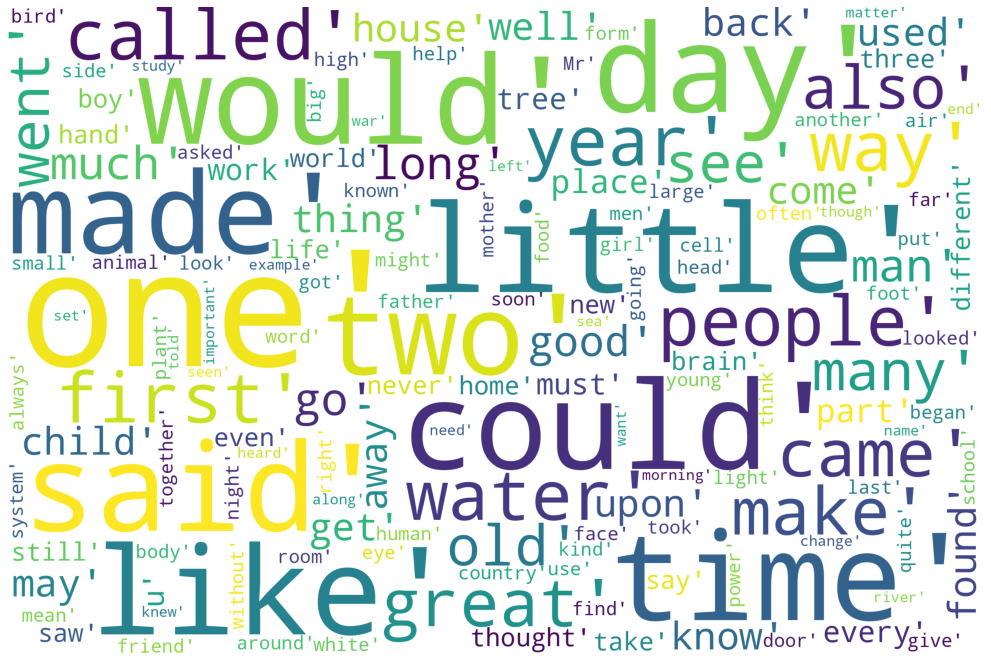

In [279]:
text = [sample.split() for sample in train_df["excerpt_preprocessed"]]
text = [word for sublist in text for word in sublist]
most_common = FreqDist(text).most_common(150)

cloud = WordCloud(
    width=1200,
    height=800,
    background_color="white",
    max_font_size=200,
    max_words=150,
    scale=2
).generate(str(most_common))

fig = plt.figure(figsize=(14,14))
plt.imshow(cloud)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Text features

In [212]:
for cols in [["excerpt", "avg_words_per_excerpt", "avg_chars_per_word"], ["excerpt_preprocessed", "avg_words_per_excerpt_preprocessed", "avg_chars_per_word_preprocessed"]]:
    texts = train_df[cols[0]].apply(lambda row: row.split())
    texts_filtered = [list(filter(None, text)) for text in texts]
    text_length = [len(text) for text in texts_filtered]
    train_df[cols[1]] = text_length

    avg_characters_per_word = list()
    for text in texts_filtered:
        characters = 0
        count = 0
        for word in text:
            characters += len(word)
            count += 1
        avg_characters_per_word.append(int(characters / count))
    train_df[cols[2]] = avg_characters_per_word

In [213]:
for cols in [["excerpt", "sentences_per_excerpt", "avg_words_per_sentence"], ["excerpt_preprocessed", "sentences_per_excerpt_preprocessed", "avg_words_per_sentence_preprocessed"]]:
    texts = train_df[cols[0]].apply(lambda row: row.split("."))
    texts_filtered = [list(filter(None, text)) for text in texts]
    text_length = [len(text) for text in texts_filtered]
    train_df[cols[1]] = text_length

    avg_words_per_sentence = list()
    for text in texts_filtered:
        words = 0
        count = 0
        for sentence in text:
            words += len(sentence.split())
            count += 1
        avg_words_per_sentence.append(int(words / count))
    train_df[cols[2]] = avg_words_per_sentence

In [222]:
train_df.head(3)

,id,url_legal,license,excerpt,target,standard_error,excerpt_preprocessed,avg_words_per_excerpt,avg_chars_per_word,avg_words_per_excerpt_preprocessed,avg_chars_per_word_preprocessed,sentences_per_excerpt,avg_words_per_sentence,sentences_per_excerpt_preprocessed,avg_words_per_sentence_preprocessed
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,young people returned ballroom presented decid...,179,4,91,5,11,16,1,91
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time Mrs Fayre somewhat silent eye rest...,169,4,85,5,10,17,1,85
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,Roger predicted snow departed quickly came two...,166,4,84,5,12,14,1,84


In [221]:
def get_kdeplot(col1, col2, title):
    sns.kdeplot(train_df[col1], color=palette[0], label="Excerpt") #, ax=ax[axis])
    sns.kdeplot(train_df[col2], color=palette[4], label="Excerpt preprocessed") #, ax=ax[axis])
    plt.title(title)
    plt.xlabel("")
    plt.legend(['Excerpt', 'Excerpt preprocessed'])

def get_scatterplot(col1, col2, title):
    sns.scatterplot(data=train_df, x=col1, y="target", color=palette[0]) #, ax=ax[axis])  # TODO: find better plot!
    sns.scatterplot(data=train_df, x=col2, y="target", color=palette[4]) #, ax=ax[axis])
    plt.title(title)
    plt.xlabel("")
    plt.legend(['Excerpt', 'Excerpt preprocessed'])

/home/hkortschak/Repositories/commonlit_kaggle/nlp-env/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


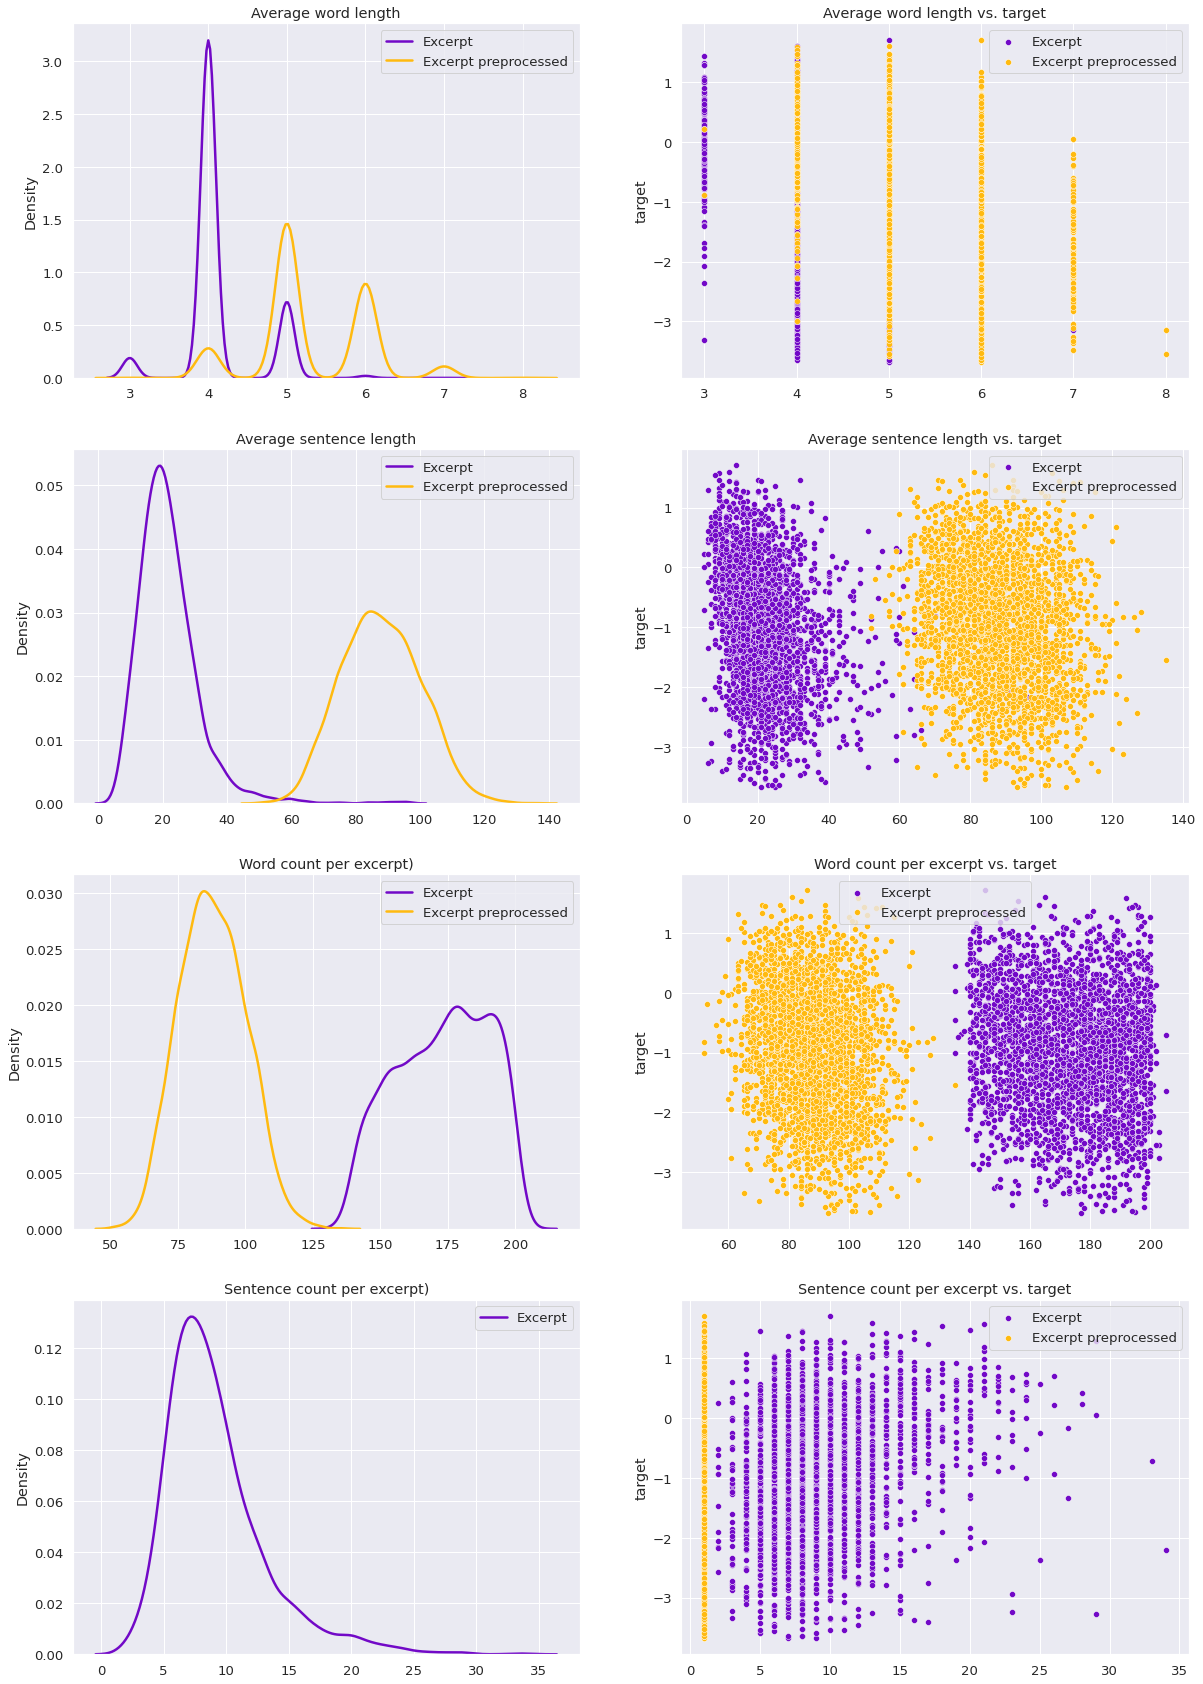

In [220]:
plt.figure(figsize=(20,30))

plt.subplot(4, 2, 1)
get_kdeplot("avg_chars_per_word", "avg_chars_per_word_preprocessed", "Average word length")
plt.subplot(4, 2, 2)
get_scatterplot("avg_chars_per_word", "avg_chars_per_word_preprocessed", "Average word length vs. target")

plt.subplot(4, 2, 3)
get_kdeplot("avg_words_per_sentence", "avg_words_per_sentence_preprocessed", "Average sentence length")
plt.subplot(4, 2, 4)
get_scatterplot("avg_words_per_sentence", "avg_words_per_sentence_preprocessed", "Average sentence length vs. target")

plt.subplot(4, 2, 5)
get_kdeplot("avg_words_per_excerpt", "avg_words_per_excerpt_preprocessed", "Word count per excerpt")
plt.subplot(4, 2, 6)
get_scatterplot("avg_words_per_excerpt", "avg_words_per_excerpt_preprocessed", "Word count per excerpt vs. target")

plt.subplot(4, 2, 7)
get_kdeplot("sentences_per_excerpt", "sentences_per_excerpt_preprocessed", "Sentence count per excerpt")
plt.subplot(4, 2, 8)
get_scatterplot("sentences_per_excerpt", "sentences_per_excerpt_preprocessed", "Sentence count per excerpt vs. target")

plt.show();